In [1]:
%pylab inline
import sys
import numpy as np
print(sys.version)
print("Last Run",str(datetime.datetime.now()))
import re

from operator import itemgetter
import pickle
import scipy.stats
import pandas as pd
import scipy as sp
import os
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib
3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:16:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Last Run 2018-07-14 22:37:30.371732


In [2]:
sb.set()

In [3]:
listOfExperiments = ["Bcl-xl_100nM_dna","BCL-xl_1nM_dna","Mcl1_100nM_dna","Mcl1_1nM_dna","BFL1_100nM_dna","Bfl1_1nM_dna"]

In [4]:
outDir = "/scratch/users/vxue/data/SORTCERY_PUBLICATION/SORTCERY_spec_dna/"

In [5]:
#SVM_Ranking_28_justin
def loadSORTCERY(file_Dir,uniqueName):
    probabilities = np.array([re.split("\s+",each.strip()) for each in 
                                  open(file_Dir+"norm_distributions_cutoff_100","r").readlines()]).astype(float)
    seqForProbs = open(file_Dir+"sequences_cutoff_100",'r').readlines()
    seqForProbs = [seqForProbs[each].strip().split() for each in range(0,len(seqForProbs))] #Get only the background and seq
    
    #ranking = [each.strip().split() for each in open("/home/vxue/luther/SORTCERY/SORTCERY2_all/ranking_cutoff_100").readlines()]
    #ranking = [int(each[0]) for each in sorted(ranking,key=lambda x: int(x[1]))]
    
    foo = pd.DataFrame({'bg':[str(each[0]) for each in seqForProbs],'seq':[each[1] for each in seqForProbs]})
    foo.loc[foo.bg==str(0),'bg']='P'
    foo.loc[foo.bg==str(1),'bg']='B'
    
    #foo['rank_2_all']=ranking
    for each in range(12):
        foo[uniqueName+'_p'+str(each)]=(probabilities[:,each])
    
    sequencesByRank = foo    
        
    expectedValue = []
    for index,each in sequencesByRank.iterrows():
        probs = each[[uniqueName+'_p'+str(gate) for gate in range(12)]].values
        expectedValue.append(np.dot(probs,np.array(range(12,0,-1))))
    sequencesByRank[uniqueName+'_expectedValue'] = expectedValue
    
    
    copyNum0 = pd.read_csv(file_Dir+'cell_counts_dnaframe_0',header=None,delimiter=' ',
                           usecols=range(12),names=[uniqueName+'_CN_'+str(each) for each in range(12)])
    copyNum1 = pd.read_csv(file_Dir+'cell_counts_dnaframe_1',header=None,delimiter=' ',
                           usecols=range(12),names=[uniqueName+'_CN_'+str(each) for each in range(12)])
    
    #uniqueSeqs0 = pd.read_csv('/home/vxue/luther/SORTCERY/SORTCERY2_Strict_a/unique_seqs_seqframe_0',header=None,delimiter=' ',names=['seq'])
    uniqueSeqs0=[each.strip() for each in open(file_Dir+'unique_seqs_dnaframe_0','r').readlines()]
    uniqueSeqs1=[each.strip() for each in open(file_Dir+'unique_seqs_dnaframe_1','r').readlines()]
    
    copyNum0['seq']=uniqueSeqs0
    copyNum1['seq']=uniqueSeqs1
    copyNum0['bg']='P'
    copyNum1['bg']='B'
    combined = copyNum0.append(copyNum1,ignore_index=True)
    combined[uniqueName+'_CN_tot']=combined[[uniqueName+'_CN_'+str(each) for each in range(12)]].sum(axis=1)
    
    
    
    sequencesByRank =  pd.merge(sequencesByRank,combined,on=['seq','bg'])

    return sequencesByRank
#sequencesByRank2_all.to_pickle("/home/vxue/luther/panda_sequenceByRank2_all.pickle")

In [6]:
#SORTCERY_Cleanup_multiplex_00-Contam_analysis

def normalizeToRate(observedCounts,totalPerGate,rate):
    probs = observedCounts/totalPerGate.astype(float)
    normCounts = probs*rate
    distOverGates = normCounts/sum(normCounts)
    return distOverGates

def reverseClusterWStd(lookupTableFile,beforeMergedDataframe,uniqueName,myRates,totalPerGate):

    lookupTable = pd.read_csv(lookupTableFile,delimiter='\t',header=None,names=('read','type','percent','percent_chimera','parent'))
    #append a UID
    uid=[]
    for index,each in lookupTable.iterrows():
        uid.append(int(each.read[0:each.read.index(';')]))
    lookupTable['uid']=uid
    
    #match up UID to original file (prior to clustering)
    fullSeqs = pd.read_csv(seqCounts,header=None,delimiter='\s+',names=('count','seq'))
    fullSeqs['uid']=range(len(fullSeqs))
    
    #merge lookup table with full seqs on UID
    lookupTable = pd.merge(lookupTable,fullSeqs,on='uid')
    
    #Set the parent of otus to themselves | This file has chimeras
    lookupTable.ix[lookupTable["type"]=='otu','parent']=lookupTable[lookupTable["type"]=='otu']['uid'].astype(str)
    
    #Merge the lookup table with the distribution information
    myMerged = pd.merge(lookupTable,beforeMergedDataframe,on='seq')
    myMerged = myMerged[(myMerged['type']=='otu') | (myMerged['type']=='match')]
    myMerged['parent']=myMerged['parent'].astype('int')
    
    #For each of the clusters, split off a child if it doesn't have the same distribution as the parent
    grouped = myMerged.groupby('parent')
    for parent,each in grouped:
        assert len(each.ix[each["type"]=='otu','seq'].values)==1
        
        parentCNCount = each[each["type"]=='otu'][[uniqueName+"_CN_"+str(i) for i in range(12)]]
        parentSeq = each.ix[each["type"]=='otu','seq'].values[0]
        parentUid = each.ix[each["type"]=='otu','uid'].values[0]
        parentProtein = each.ix[each["type"]=='otu','protein'].values[0]
        
        
        for index,clone in each[each["type"]=='match'].iterrows():
            
            childCNCount = clone[[uniqueName+"_CN_"+str(i) for i in range(12)]]
            childUID = clone['uid']
            childSeq = clone['seq']
            childProtein = clone['protein']

            
            #Take the observed counts of reads and normalize it to 
            observedCounts = np.array(childCNCount)
            normalizedObserved = normalizeToRate(observedCounts+1,totalPerGate,myRates)*sum(observedCounts)

            #expectedCounts = ((np.array(parentCNCount)/sum(np.array(parentCNCount)).astype(float))*sum(np.array(childCNCount))).ravel()
            #expectedCounts= expectedCounts+1 # Pseudo count
            normalizedExpected = normalizeToRate(np.array(parentCNCount)[0]+1,totalPerGate,myRates)*sum(observedCounts)

            
            #The smaller the alpha level, the more confident you are that the distributions are different.
            #That means that you are less likely to split the cluster
            # Closer to zero => less clusters
            pValue = scipy.stats.chisquare(normalizedObserved,f_exp=normalizedExpected)[1]
            myMerged.ix[myMerged['uid']==childUID,'pValue'] = pValue
            
            alphaLevel = 0.005/len(clone)
            
            if(pValue<alphaLevel): #<10**-150
                #print "-",childUID
                #Undo cluster
                myMerged.ix[myMerged['uid']==childUID,'new_parent']=childUID
                myMerged.ix[myMerged['uid']==childUID,'new_protein']=childProtein
                myMerged.ix[myMerged['uid']==childUID,'new_seq']=childSeq
            else:
                
                myMerged.ix[myMerged['uid']==childUID,'new_parent']=parentUid
                myMerged.ix[myMerged['uid']==childUID,'new_protein']=parentProtein
                myMerged.ix[myMerged['uid']==childUID,'new_seq']=parentSeq
                #print "+",childUID,parentUid
                
    return myMerged

In [7]:
listOfExperiments

['Bcl-xl_100nM_dna',
 'BCL-xl_1nM_dna',
 'Mcl1_100nM_dna',
 'Mcl1_1nM_dna',
 'BFL1_100nM_dna',
 'Bfl1_1nM_dna']

In [8]:
rates_bclxl_100 = [51256,40888,29279,18669,18234,21523,24244,27958,35279,43143,46700,37836]
rates_bclxl_1nm = [108816,63075,33091,28486,32486,33064,30803,30284,19654,17593,13249,10114]
rates_mcl1_100  = [51337,41241,30046,21504,24453,28237,32029,37473,45272,53483,58340,47667]
rates_mcl1_1nm  = [26652,19849,14471,9163,7842,7943,8315,8438,8643,9631,9740,9027]
rates_bfl1_100  = [56015,35689,24587,22812,23952,25822,23090,28836,28230,27094,18069,11434]
rates_bfl1_1nm  = [30167,15783,8328,7387,8191,7941,7073,7972,7445,6830,4801,2598]

allRates = [rates_bclxl_100,rates_bclxl_1nm,rates_mcl1_100,rates_mcl1_1nm,rates_bfl1_100,rates_bfl1_1nm]

In [9]:
baseName = "/scratch/users/vxue/data/SORTCERY_PUBLICATION/SORTCERY_spec_dna/workspace/"
allSeqCount = []
allLookupTable = []
for each in listOfExperiments:
    txtOutDir = baseName+each+"/diversity.txt"    
    allSeqCount.append(txtOutDir)
    lookupTable = baseName+each+"/out.up"
    allLookupTable.append(lookupTable)

# Look at Bclxl data first - the rest can be automated later

In [10]:
lookupTableFile = allLookupTable[0]
seqCounts = allSeqCount[0]
uniqueName = listOfExperiments[0]
beforeMergedDataframe = loadSORTCERY(baseName+listOfExperiments[0]+"/",uniqueName)
totalPerGate = np.array(beforeMergedDataframe[[uniqueName+"_CN_"+str(i) for i in range(12)]].sum(axis=0))
myRates = allRates[0]

In [11]:
print (len(beforeMergedDataframe))
print (len(beforeMergedDataframe.seq.unique()))
print (beforeMergedDataframe[uniqueName+"_CN_tot"].sum())
#Assert that the dna sequences can be mapped uniquely to a bg
beforeMergedDataframe = beforeMergedDataframe.groupby('seq').filter(lambda x: len(x)==1)
print (len(beforeMergedDataframe))
print (len(beforeMergedDataframe.seq.unique()))
print (beforeMergedDataframe[uniqueName+"_CN_tot"].sum())


5917
5917
3140919
5917
5917
3140919


In [12]:
# Append the Protein sequence to the array

from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

proteinSeqs = []
for index,each in beforeMergedDataframe.iterrows():
    my_seq = Seq(each['seq'],generic_dna).translate()
    proteinSeqs.append(str(my_seq))
beforeMergedDataframe['protein']=proteinSeqs

In [13]:
updatedCluster = reverseClusterWStd(lookupTableFile,beforeMergedDataframe,uniqueName,myRates,totalPerGate)
updatedCluster.ix[updatedCluster.new_parent.isnull(),'new_parent']=updatedCluster[updatedCluster.new_parent.isnull()]['parent']
updatedCluster.ix[updatedCluster.new_seq.isnull(),'new_seq']=updatedCluster[updatedCluster.new_seq.isnull()]['seq']
updatedCluster.ix[updatedCluster.new_protein.isnull(),'new_protein']=updatedCluster[updatedCluster.new_protein.isnull()]['protein']

/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/ipykernel/__main__.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/ipykernel/__main__.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/ipykernel/__main__.py:65: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [14]:
x_b = "GGCCGTCCG[ACG][AT][CG]ATTTGG[ACGT][AT]TGCGCAGGAACTG[AG][CGT]ACGT[ACGT][ACGT]CG[CG]CGATGAATTT[ACG][ACT]C[AG][AC]ATAT[ACGT][ACG]C"
m_b = "GGCCGT[ACGT][CG]GGAA[CGT][ACGT]C[CG]A[AT][AG][CT]C[AG][CGT]TCAGGAACTG[AG][ACGT]ACGTATTGGCGATGAA[ACGT][ACT]T[ACG]A[GT]GCGTATTAT"
f_b = "GGCCGTCCG[ACG][ACT]AATTTGGATT[GT][ACG]TCAG[ACGT][AGT]CCTGCGTCGT[ACGT][CGT]CGGCGAT[ACG][AT][GT][ACGT][ACT]TAATGCGTAT[ACGT][CT]T"
x_p = "GGCCAATGG[ACG][AT][CG]CGTGAA[ACGT][AT]TGGCGCCCAACTG[AG][CGT]ACGC[ACGT][ACGT]CG[CG]CGATGATCTG[ACG][ACT]C[AG][AC]ACAA[ACGT][ACG]C"
m_p = "GGCCAA[ACGT][CG]GGCG[CGT][ACGT]C[CG]A[AT][AG][CT]C[AG][CGT]TGCCCAACTG[AG][ACGT]ACGCATGGCGGATGAT[ACGT][ACT]T[ACG]A[GT]GCCCAATAT"
f_p = "GGCCAATGG[ACG][ACT]ACGTGAAATT[GT][ACG]TGCC[ACGT][AGT]CCTGCGTCGC[ACGT][CGT]CGCGGAT[ACG][AT][GT][ACGT][ACT]TAATGCCCAA[ACGT][CT]T"
justinRegex = "|".join([x_b,m_b,f_b,x_p,m_p,f_p])

luther_bim =  "GGCCGTCCGGAAATTTGG[ATG][ACT]TGCGCAGGAA[ATGC][TC]T[ACG][AG][TG]CGT[ATG][ACT]TGGC[ACG][AG][TG]GAA[ATG][ACT]TAATGCGTATTAT"
luther_puma = "GAACAATGGGCGCGTGAA[ATG][ACT]TGGC[G][C][C]CAA[ATGC][TC]T[ACG][AG][TG]CGC[ATG][ACT]TGCG[ACG][AG][TG]GAT[ATG][ACT]TAATGCCCAATAT"
lutherRegex = "|".join([luther_bim,luther_puma])

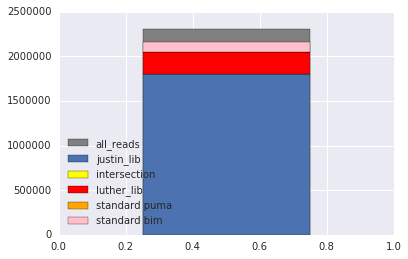

In [15]:
lutherBool = updatedCluster.new_seq.str.contains(lutherRegex) 
justinBool = updatedCluster.new_seq.str.contains(justinRegex)

fig,ax = plt.subplots()

asDesigned = sum(updatedCluster[~lutherBool & justinBool])[uniqueName+'_CN_tot']
asContaminant = sum(updatedCluster[lutherBool & ~justinBool])[uniqueName+'_CN_tot']
asUnknown = np.nan_to_num(sum(updatedCluster[lutherBool & justinBool])[uniqueName+'_CN_tot'])

asBim = updatedCluster[updatedCluster.new_seq.str.contains(luther_bim)][uniqueName+'_CN_tot'].sum()
asPuma = updatedCluster[updatedCluster.new_seq.str.contains(luther_puma)][uniqueName+'_CN_tot'].sum()

asStandardPuma = updatedCluster[updatedCluster.new_seq.str.contains('GAACAATGGGCGCGTGAAATTGGCGCCCAACTGCGTCGCATGGCGGATGATCTGAAT')][uniqueName+'_CN_tot'].sum()
asStandardBim = updatedCluster[updatedCluster.new_seq.str.contains('GGCCGTCCGGAAATTTGGATTGCGCAGGAACTGCGTCGTATTGGCGATGAATTTAAT')][uniqueName+'_CN_tot'].sum()


ax.bar(0.25,sum(updatedCluster[uniqueName+'_CN_tot']),0.5,color='grey',label='all_reads')
ax.bar(0.25,asDesigned,0.5,label='justin_lib')
ax.bar(0.25,asUnknown,0.5,bottom=asDesigned,label='intersection',color='yellow')
ax.bar(0.25,asContaminant,0.5,bottom=asUnknown+asDesigned,label='luther_lib',color='red')
ax.bar(0.25,asStandardPuma,0.5,bottom=asUnknown+asDesigned+asContaminant,label='standard puma',color='orange')
ax.bar(0.25,asStandardBim,0.5,bottom=asUnknown+asDesigned+asContaminant+asStandardPuma,label='standard bim',color='pink')

ax.set_xlim(0,1)
ax.legend(loc=0)


In [16]:
for index, each in updatedCluster.groupby("new_protein"):
    # Sometimes when combining clusters on protein sequence, there may be multiple OTUs.
    # For each cluster, find the one with the most counts and set that as the new parent.
    updatedCluster.ix[updatedCluster.uid.isin(each.uid),'new_new_parent']=each.sort_values(uniqueName+'_CN_tot',ascending=False)[0:1]['uid'].values[0]

In [17]:
print (len(updatedCluster)) #Before clustering
print (len(updatedCluster.groupby('parent').sum())) #After clustering
print (len(updatedCluster.groupby('new_parent').sum())) #After clustering + unclustering
print
print (len(updatedCluster.groupby('new_new_parent').sum())) #After clustering + unclustering + Reclustering
print (len(updatedCluster.groupby('new_protein').sum())) #After clustering + unclustering + Reclustering

4550
4170
4424
4372
4372


In [18]:
len(updatedCluster[~lutherBool].groupby('new_new_parent').sum())

4128

In [19]:
lookupArray = {'A':np.array([1,0,0,0]),
               'C':np.array([0,1,0,0]),
               'G':np.array([0,0,1,0]),
               'T':np.array([0,0,0,1])}

def convertDNARegexToVector(regexString):
    myVector = []
    tempSum = np.zeros(4)
    fillInTemp = False
    
    for each in regexString:
        if(each=="["):
            tempSum=np.zeros(4)
            fillInTemp = True
            continue
        elif(each==']'):
            fillInTemp=False
            myVector.append(tempSum.astype(int))
            continue
            
        if(fillInTemp):
            tempSum= tempSum + lookupArray[each]
        else:
            myVector.append(lookupArray[each])
    return np.array(myVector).flatten()


def getClosestJustinLib(seq):
    myArray = []
    myArray.append(convertDNARegexToVector(x_b).dot(convertDNARegexToVector(seq)))
    myArray.append(convertDNARegexToVector(m_b).dot(convertDNARegexToVector(seq)))
    myArray.append(convertDNARegexToVector(f_b).dot(convertDNARegexToVector(seq)))
    myArray.append(convertDNARegexToVector(x_p).dot(convertDNARegexToVector(seq)))
    myArray.append(convertDNARegexToVector(m_p).dot(convertDNARegexToVector(seq)))
    myArray.append(convertDNARegexToVector(f_p).dot(convertDNARegexToVector(seq)))

    return 66 - max(myArray)

def getClosestLutherLib(seq):
    myArray = []
    myArray.append(convertDNARegexToVector(luther_bim).dot(convertDNARegexToVector(seq)))
    myArray.append(convertDNARegexToVector(luther_puma).dot(convertDNARegexToVector(seq)))

    return 66 - max(myArray)

In [20]:

bimVector =  convertDNARegexToVector("GGCCGTCCGGAAATTTGGATTGCGCAGGAACTGCGTCGTATTGGCGATGAATTTAATGCGTATTAT")
pumaVector = convertDNARegexToVector("GAACAATGGGCGCGTGAAATTGGCGCCCAACTGCGTCGCATGGCGGATGATCTGAATGCCCAATAT")

In [21]:
updatedCluster['numMutFromJustin'] = updatedCluster.apply(lambda x : getClosestJustinLib(x.new_seq),axis=1)
updatedCluster['numMutFromLuther'] = updatedCluster.apply(lambda x : getClosestLutherLib(x.new_seq),axis=1)
updatedCluster['numMutFromBim'] = updatedCluster.apply(lambda x : 66-(convertDNARegexToVector(x.new_seq).dot(bimVector)),axis=1)
updatedCluster['numMutFromPuma'] = updatedCluster.apply(lambda x : 66-(convertDNARegexToVector(x.new_seq).dot(pumaVector)),axis=1)

In [22]:
def categorizeByMut(x):
    label = ['numMutFromBim','numMutFromPuma','numMutFromJustin','numMutFromLuther']
    myArray = []
    myArray.append(x['numMutFromBim'])
    myArray.append(x['numMutFromPuma'])
    myArray.append(x['numMutFromJustin'])
    myArray.append(x['numMutFromLuther'])
    return label[myArray.index(min(myArray))]

In [23]:
updatedCluster['mostLikelySource'] = updatedCluster[(~lutherBool) & (~justinBool)].apply(lambda x: categorizeByMut(x) , axis =1 )

In [24]:
updatedCluster.groupby('mostLikelySource')[uniqueName+'_CN_tot'].sum()

mostLikelySource
numMutFromBim       133118
numMutFromJustin     63706
numMutFromLuther     51444
numMutFromPuma        6018
Name: Bcl-xl_100nM_dna_CN_tot, dtype: int64

In [25]:
updatedCluster[(~lutherBool) & (~justinBool)][['seq','numMutFromBim','numMutFromPuma','numMutFromJustin','numMutFromLuther']]

,seq,numMutFromBim,numMutFromPuma,numMutFromJustin,numMutFromLuther
0,GGCCGTCCGGAAATTTGGATTGCGCAGGAACTGCGTCGTATTGGCG...,0,29,5,1
7,GGCCGTCCGGAAATTTGGTATTCTCAGTTTATCCGTCGTATTGGCG...,10,36,8,6
8,GGCCGTCCGGAAATTTGGATTGCGCAGGAATTGCGTCGTATTGGCG...,1,30,6,1
20,GGCCAATGGGCGCGTGAAATTGGCGCCCAACTGCGTCGCATGGCGG...,27,2,6,6
28,GGCCGTCCGGAAATTTGGGTTGCGCAGGAACTGCGTCGTATTGGCG...,1,30,6,1
80,GGCCGTCCGGAAATTTGGTATGCGCAGGGGCTCAAACGTTTCGGCG...,10,38,8,5
87,GGCCGTCCGGAAATTTGGATTGCTCAGGATCTCCGTCGTCATGGCG...,7,32,7,5
115,GGCCGTCCGGAAATTTGGGTTGCGCAGGCCACTTAAGCGTATTGGC...,17,43,18,9
132,GGCCGTCCGATAATTTGGATTTGTCAGGACCTGCGTAGTGTCGGCG...,12,32,1,12
133,GGCCAATGGGTGAGTGAAGATGGCGCCCAACTGACACGCTACGCCG...,38,20,1,18


In [26]:
hypoSource = updatedCluster[~updatedCluster.new_seq.str.contains("GGCCGTCCGGAAATTTGGATTGCGCAGGAACTGCGTCGTATTGGCGATGAATTTAATGCGTATTAT|GAACAATGGGCGCGTGAAATTGGCGCCCAACTGCGTCGCATGGCGGATGATCTGAATGCCCAATAT")].groupby('mostLikelySource')[uniqueName+'_CN_tot'].sum()

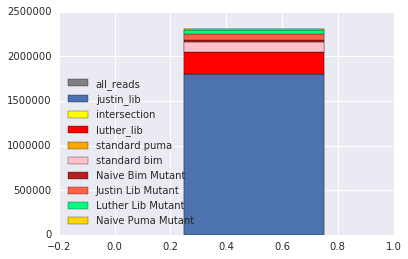

In [27]:
lutherBool = updatedCluster.new_seq.str.contains(lutherRegex) 
justinBool = updatedCluster.new_seq.str.contains(justinRegex)

fig,ax = plt.subplots()

asDesigned = sum(updatedCluster[~lutherBool & justinBool])[uniqueName+'_CN_tot']
asContaminant = sum(updatedCluster[lutherBool & ~justinBool])[uniqueName+'_CN_tot']
asUnknown = np.nan_to_num(sum(updatedCluster[lutherBool & justinBool])[uniqueName+'_CN_tot'])

asBim = updatedCluster[updatedCluster.new_seq.str.contains(luther_bim)][uniqueName+'_CN_tot'].sum()
asPuma = updatedCluster[updatedCluster.new_seq.str.contains(luther_puma)][uniqueName+'_CN_tot'].sum()

asStandardPuma = updatedCluster[updatedCluster.new_seq.str.contains('GAACAATGGGCGCGTGAAATTGGCGCCCAACTGCGTCGCATGGCGGATGATCTGAAT')][uniqueName+'_CN_tot'].sum()
asStandardBim = updatedCluster[updatedCluster.new_seq.str.contains('GGCCGTCCGGAAATTTGGATTGCGCAGGAACTGCGTCGTATTGGCGATGAATTTAAT')][uniqueName+'_CN_tot'].sum()


myBottom = 0
ax.bar(0.25,sum(updatedCluster[uniqueName+'_CN_tot']),0.5,color='grey',label='all_reads')

ax.bar(0.25,asDesigned,0.5,label='justin_lib')
myBottom+=asDesigned
ax.bar(0.25,asUnknown,0.5,bottom=myBottom,label='intersection',color='yellow')
myBottom+=asUnknown
ax.bar(0.25,asContaminant,0.5,bottom=myBottom,label='luther_lib',color='red')
myBottom+=asContaminant
ax.bar(0.25,asStandardPuma,0.5,bottom=myBottom,label='standard puma',color='orange')
myBottom+=asStandardPuma
ax.bar(0.25,asStandardBim,0.5,bottom=myBottom,label='standard bim',color='pink')
myBottom+=asStandardBim

ax.bar(0.25,hypoSource['numMutFromBim'],0.5,bottom=myBottom,label='Naive Bim Mutant',color='firebrick')
myBottom+=hypoSource['numMutFromBim']
ax.bar(0.25,hypoSource['numMutFromJustin'],0.5,bottom=myBottom,label='Justin Lib Mutant',color='tomato')
myBottom+=hypoSource['numMutFromJustin']
ax.bar(0.25,hypoSource['numMutFromLuther'],0.5,bottom=myBottom,label='Luther Lib Mutant',color='springgreen')
myBottom+=hypoSource['numMutFromLuther']
ax.bar(0.25,hypoSource['numMutFromPuma'],0.5,bottom=myBottom,label='Naive Puma Mutant',color='gold')


ax.set_xlim(-0.2,1)
ax.legend(loc=0)


In [28]:
updatedCluster.to_pickle("/home/vxue/data/SORTCERY_PUBLICATION/SORTCERY_spec_dna/workspace/processed/multiplex_bclxl_100.pickle")

## Collect Stats to be used for collective plot

In [29]:
[beforeMergedDataframe[uniqueName+"_CN_tot"].sum(),
asDesigned,
asUnknown,
asContaminant,
asStandardPuma,
asStandardBim,
hypoSource['numMutFromBim'],
hypoSource['numMutFromJustin'],
hypoSource['numMutFromLuther'],
hypoSource['numMutFromPuma'],
beforeMergedDataframe[beforeMergedDataframe.seq.str.contains("N")][uniqueName+"_CN_tot"].sum()]

[3140919, 1798221, 0.0, 248572, 175, 111758, 22374, 63706, 51444, 5843, 786141]

In [30]:
hypoSource

mostLikelySource
numMutFromBim       22374
numMutFromJustin    63706
numMutFromLuther    51444
numMutFromPuma       5843
Name: Bcl-xl_100nM_dna_CN_tot, dtype: int64

In [31]:
def countMut(x):
    label = ['numMutFromBim','numMutFromPuma','numMutFromJustin','numMutFromLuther']
    myArray = []
    myArray.append(x['numMutFromBim'])
    myArray.append(x['numMutFromPuma'])
    myArray.append(x['numMutFromJustin'])
    myArray.append(x['numMutFromLuther'])
    return min(myArray)

In [32]:
updatedCluster['diffFromMostLikelySource'] = updatedCluster[(~lutherBool) & (~justinBool)].apply(lambda x: countMut(x) , axis =1 )

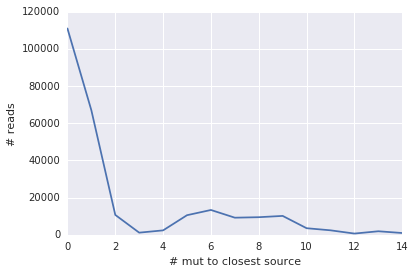

In [33]:
myData = updatedCluster[(~lutherBool) & (~justinBool)].groupby(['diffFromMostLikelySource']).sum()[uniqueName+'_CN_tot']
plot(myData.index,myData)
xlabel("# mut to closest source")
ylabel("# reads")

In [34]:
#SVM_Ranking_29
from weblogolib import *
from IPython.display import Image


def makeLogoFromList(sequences):
    myFile = open("/tmp/seqlogo",'w')
    count = 0
    for each in sequences:
        if("*" not in each and "X" not in each):
            myFile.write(each+"\n")
            #myFile.write("\n")
        count+=1
        #if (count>10000):
        #    break
    myFile.close()
    
    myFile=open("/tmp/seqlogo",'r')
    seqs = read_seq_data(myFile)
    data = LogoData.from_seqs(seqs)
    options = LogoOptions()
    options.fineprint=""
    options.resolution=300
    options.fontsize=8
    options.unit_name="probability"
    myFormat = LogoFormat(data, options)
    return png_formatter(data,myFormat)

temp = makeLogoFromList(['AATCGA'])
myFile=open("/tmp/seqlogo",'r')
seqs = read_seq_data(myFile)   
data = LogoData.from_seqs(seqs)


In [35]:
#SORTCERY_Cleanup_multiplex_00-Contam_analysis
def makeLogoFromDataFrame_AA(myData,column,uniqueName):
    
    aaLookup = "ACDEFGHIKLMNPQRSTVWY"
    length = len(updatedCluster[column][0])
    
    makeLogoFromList([updatedCluster[column][0]])

    
    myArray = np.zeros((length,20))
    for each in range(length):
        for aaIndex in range(20):
                myArray[each][aaIndex]=np.nansum(myData[(myData[column].str.contains("^"+"."*each+aaLookup[aaIndex]))]\
                                           [uniqueName+'_CN_tot'])
            
    myFile=open("/tmp/seqlogo",'r')
    seqs = read_seq_data(myFile)   
    data = LogoData.from_seqs(seqs)
    #A little hack
    data.counts.array=myArray.tolist()
    
    options = LogoOptions()
    options.fineprint=""
    options.resolution=300
    options.fontsize=8
    options.unit_name="probability"
    myFormat = LogoFormat(data, options)
    return png_formatter(data,myFormat)


def makeLogoFromDataFrame_DNA(myData,column,uniqueName):

    aaLookup = "ACGT"
    length = len(updatedCluster[column][0])
    
    makeLogoFromList([updatedCluster[column][0]])
    
    myArray = np.zeros((length,4))
    
    for each in range(length):
        for aaIndex in range(4):
                myArray[each][aaIndex]=np.nansum(myData[(myData[column].str.contains("^"+"."*each+aaLookup[aaIndex]))]\
                                           [uniqueName+'_CN_tot'])
                
    myFile=open("/tmp/seqlogo",'r')
    seqs = read_seq_data(myFile)   
    data = LogoData.from_seqs(seqs)
    #A little hack
    data.counts.array=myArray.tolist()
    
    options = LogoOptions()
    options.fineprint=""
    options.resolution=300
    options.fontsize=8
    options.unit_name="probability"
    myFormat = LogoFormat(data, options)
    return png_formatter(data,myFormat)

In [36]:
sanjib = updatedCluster[(~lutherBool) & (~justinBool) & (updatedCluster['diffFromMostLikelySource']>4)]

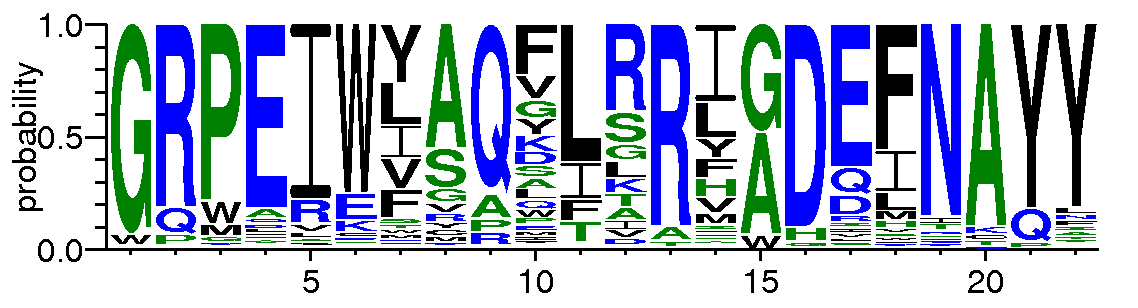

In [37]:
Image(makeLogoFromDataFrame_AA(sanjib,'new_protein',uniqueName))

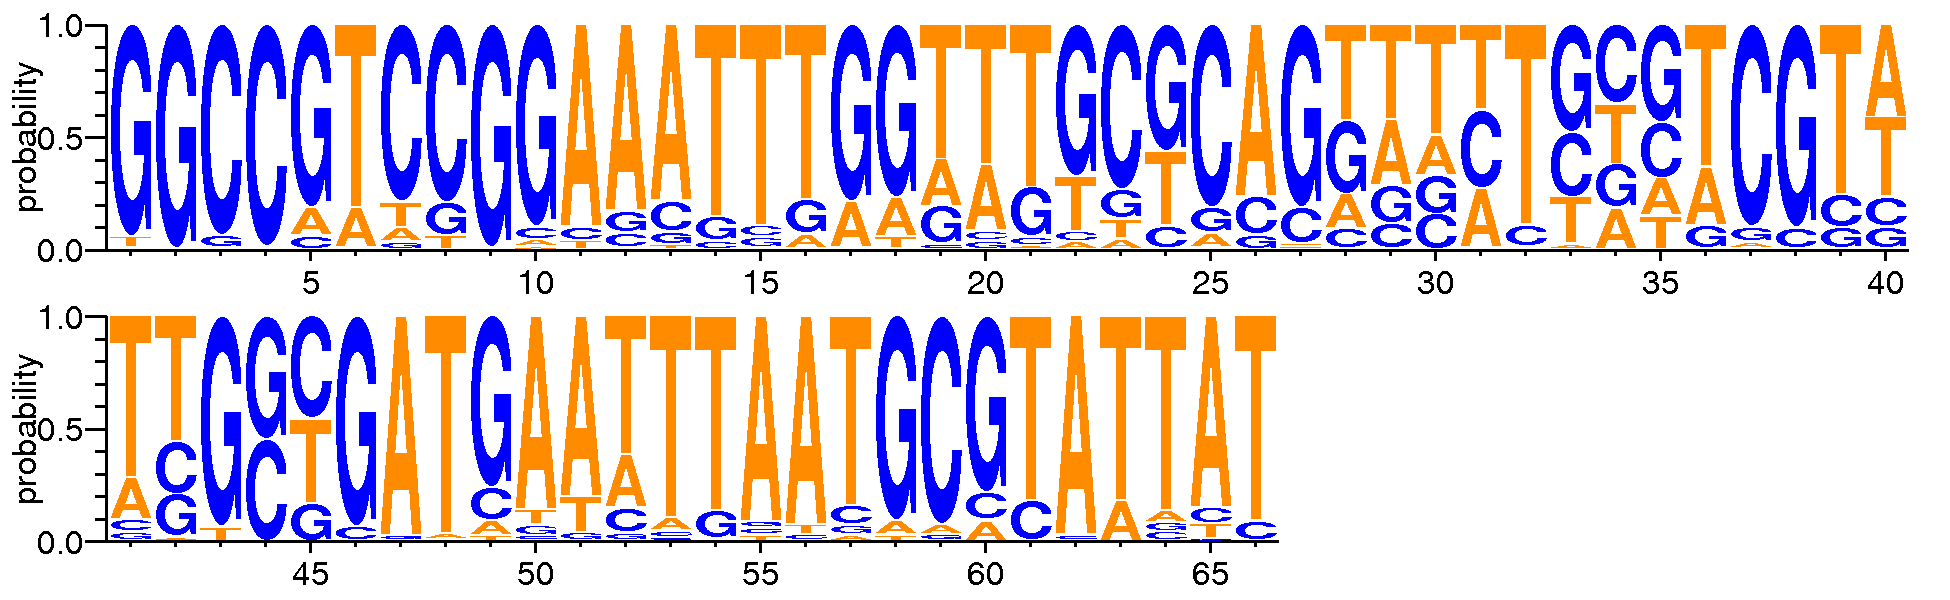

In [38]:
Image(makeLogoFromDataFrame_DNA(sanjib,'new_seq',uniqueName))

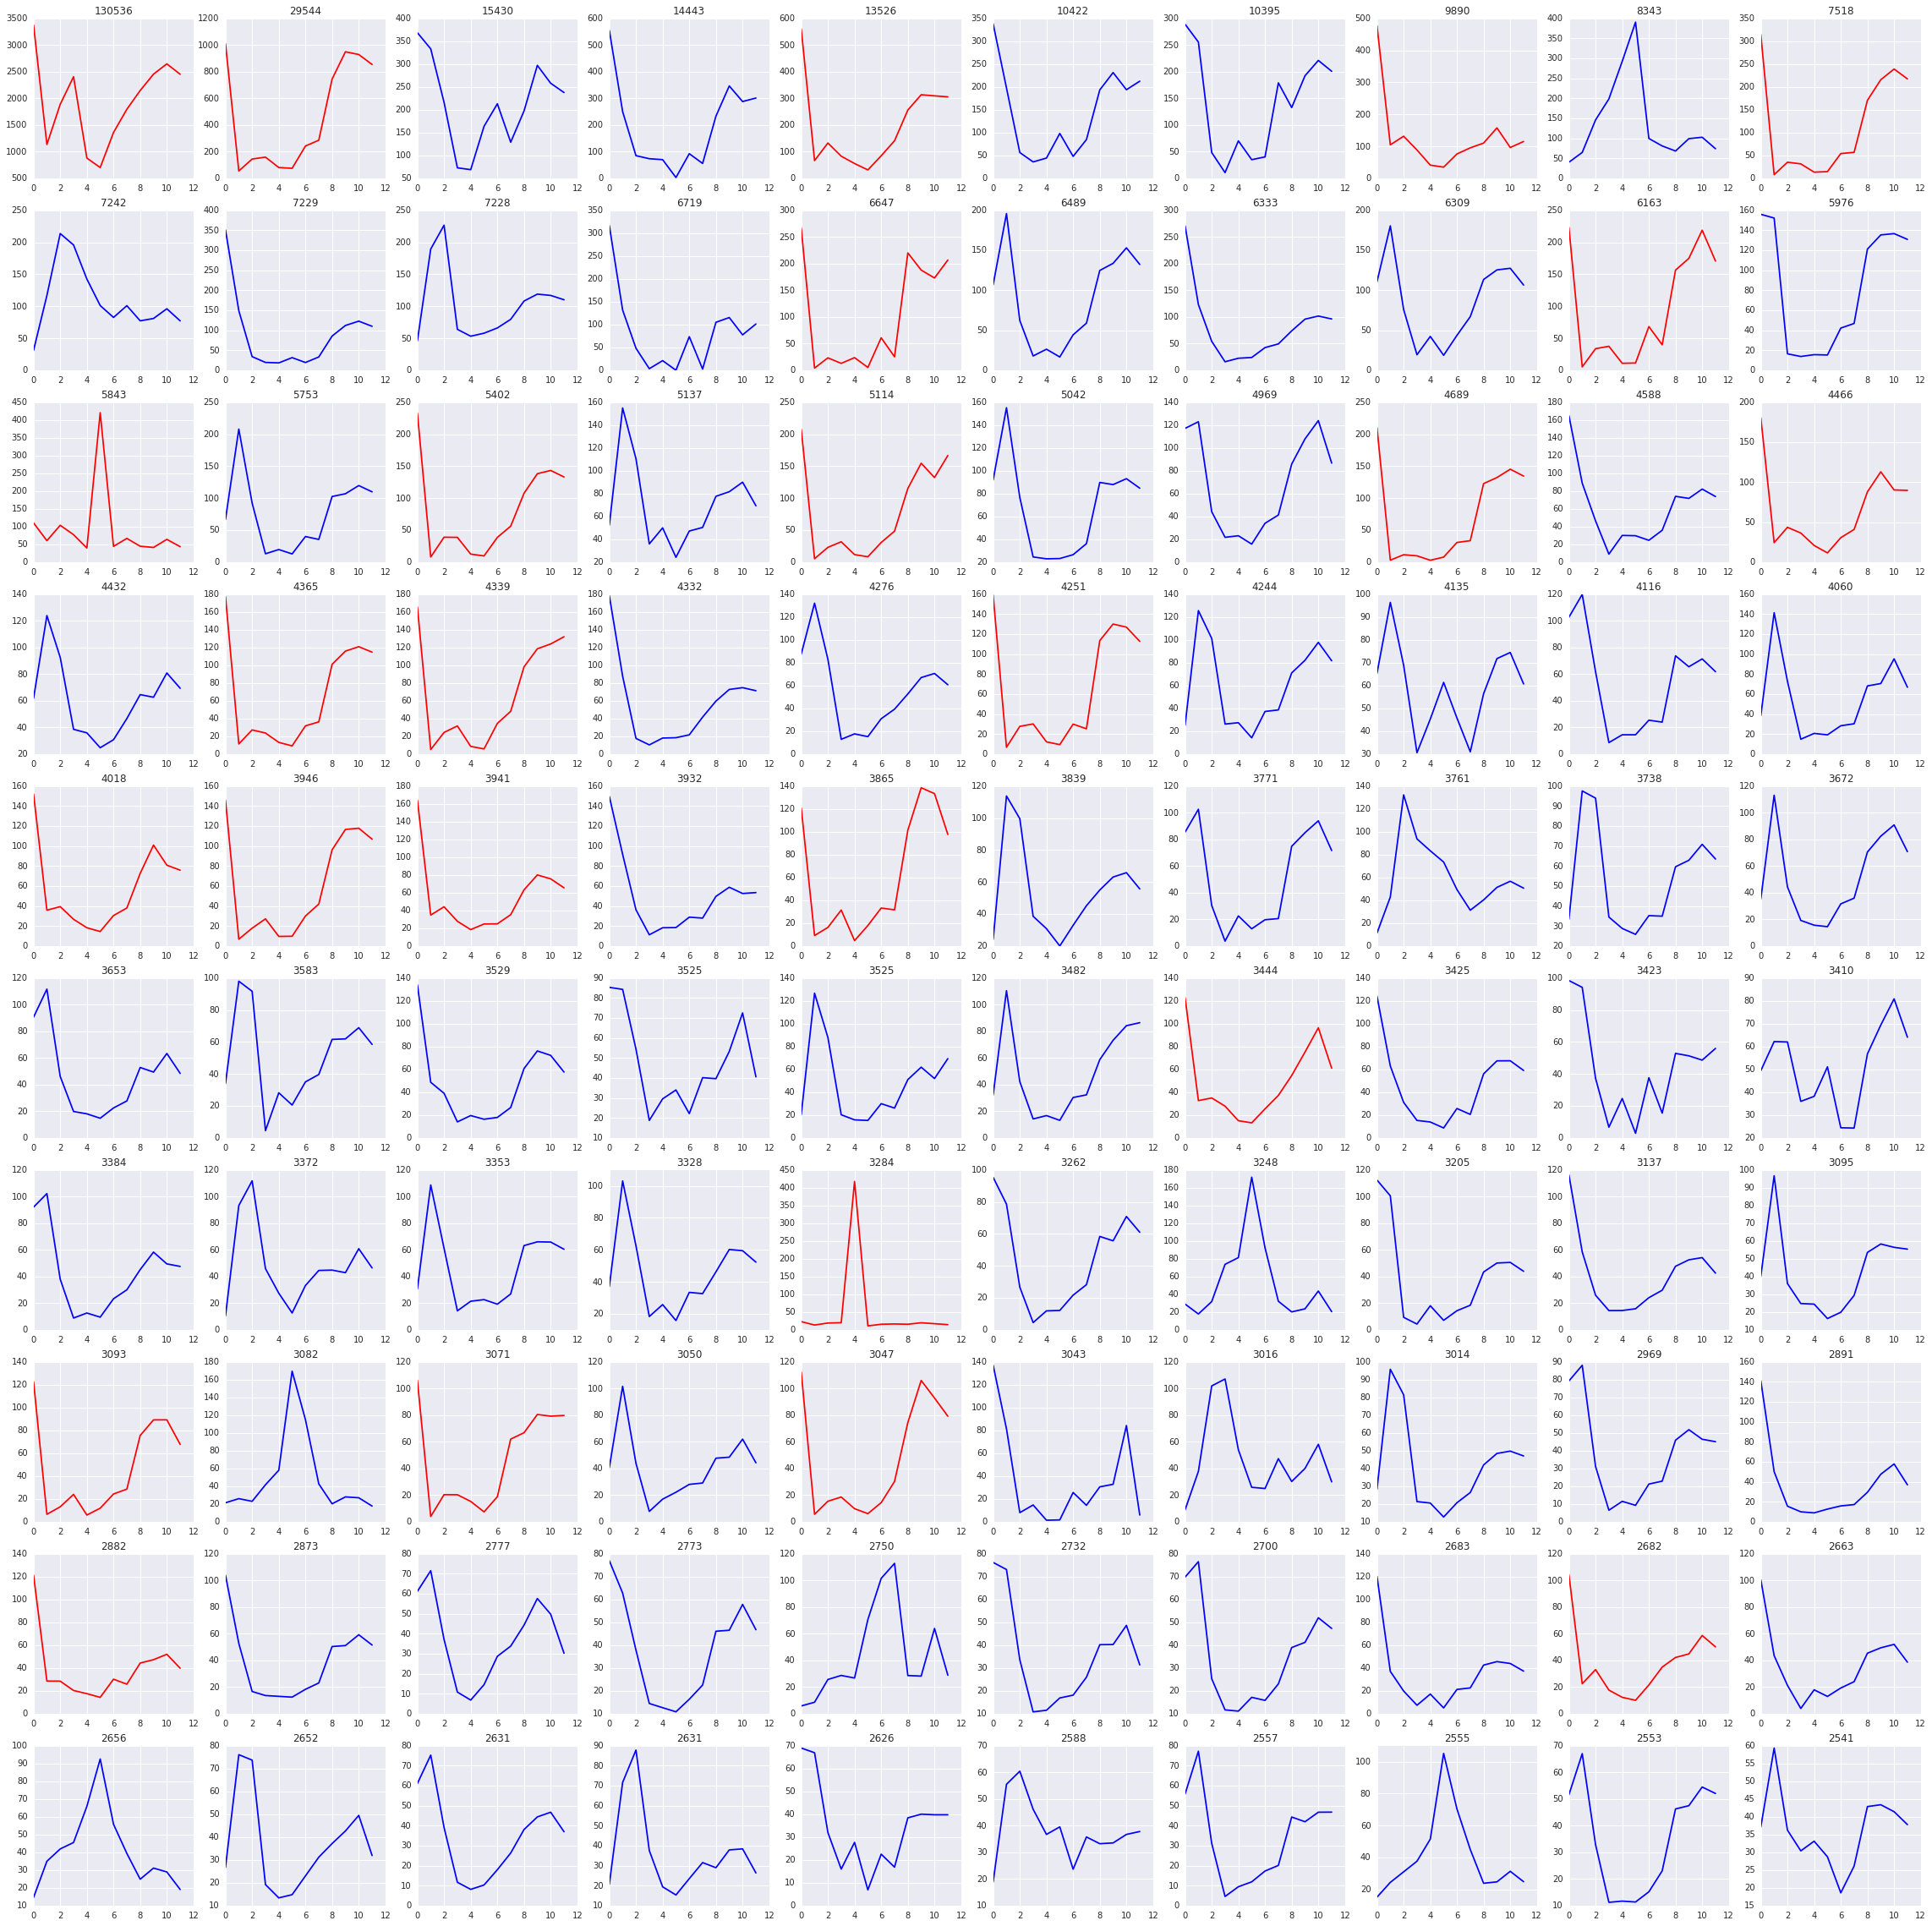

In [39]:
updatedCluster['isJustin']=updatedCluster['new_seq'].str.contains(justinRegex)

myExtractArray = [uniqueName+'_CN_'+str(i) for i in range(12)]
myExtractArray.append('isJustin')

copyNums = updatedCluster.groupby('new_protein').sum()[myExtractArray].reset_index()

probs = myRates*(copyNums[[uniqueName+'_CN_'+str(i) for i in range(12)]] / copyNums.sum(axis=0)[[uniqueName+'_CN_'+str(i) for i in range(12)]])
probs['CN_tot'] = copyNums[[uniqueName+'_CN_'+str(i) for i in range(12)]].sum(axis=1)
probs['seq'] = copyNums['new_protein']
probs['isJustin'] = copyNums['isJustin']

fig,ax = plt.subplots(10,10,figsize=(40,40))

for each in range(0,100):
    row = each//10
    column = each%10
    oneoff = probs.sort_values('CN_tot',ascending=False).head(each+1).tail(1)
    
    if(oneoff['isJustin'].values[0]>0):
        myColor = 'blue'
    else:
        myColor = 'red'
        
    ax[row][column].plot(np.array(oneoff[[uniqueName+'_CN_'+str(i) for i in range(12)]]).astype(float)[0],color=myColor)
    ax[row][column].set_title(oneoff['CN_tot'].values[0])
    

# Showing on Justin Profiles

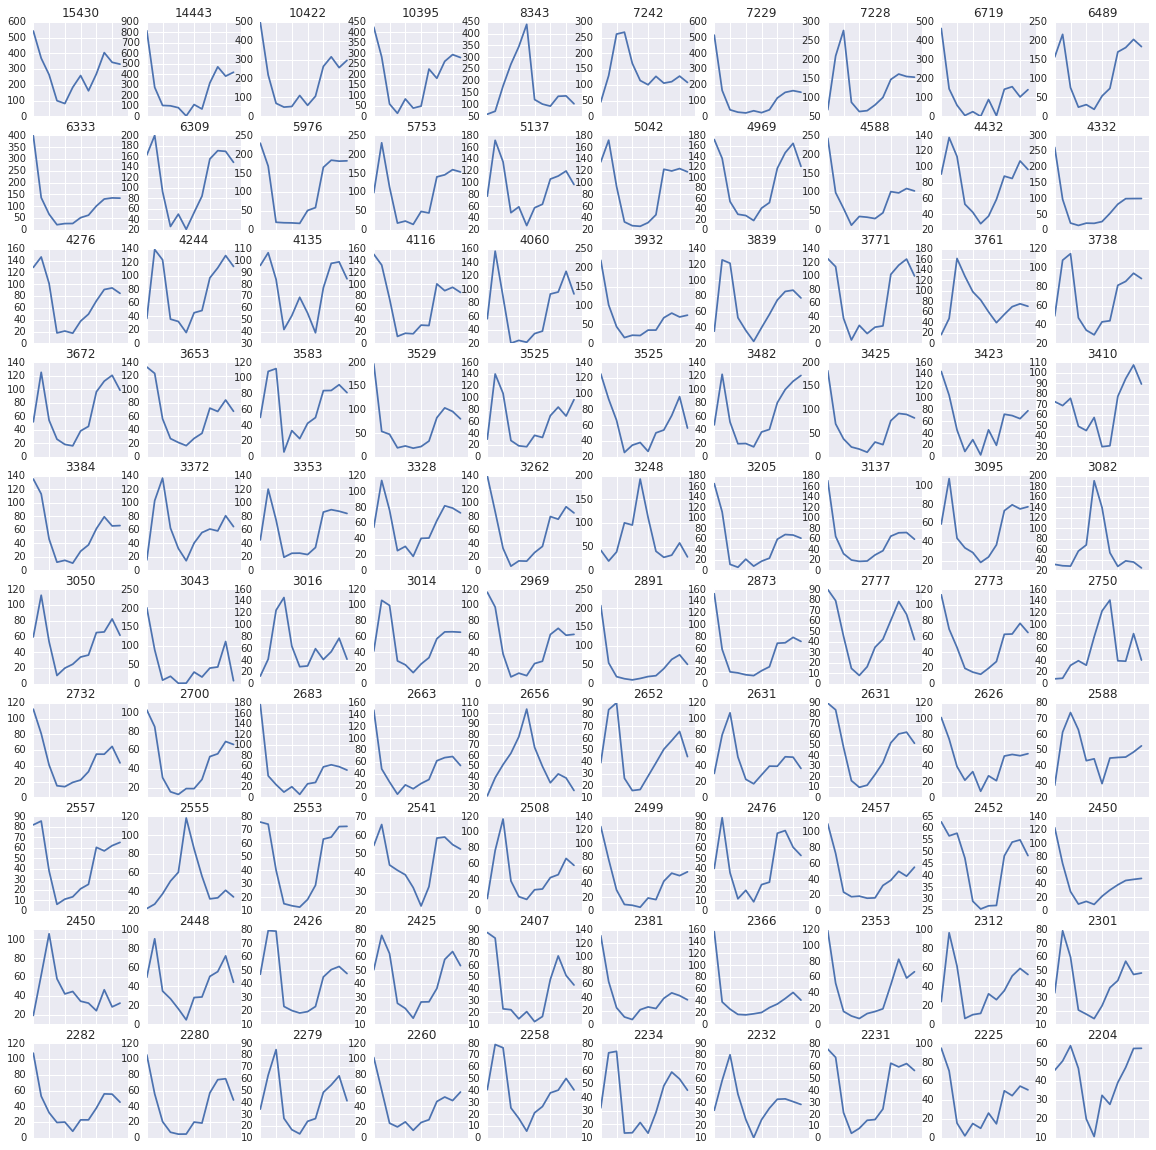

In [40]:

copyNums = updatedCluster[justinBool].groupby('new_protein').sum()[[uniqueName+'_CN_'+str(i) for i in range(12)]].reset_index()

probs = myRates*(copyNums[[uniqueName+'_CN_'+str(i) for i in range(12)]] / copyNums.sum(axis=0)[[uniqueName+'_CN_'+str(i) for i in range(12)]])
probs['CN_tot'] = copyNums.sum(axis=1)
probs['seq'] = copyNums['new_protein']
fig,ax = plt.subplots(10,10,figsize=(20,20))

myData = probs.sort_values('CN_tot',ascending=False)

for each in range(0,100):
    row = each//10
    column = each%10
    oneoff = myData.head(each+1).tail(1)
    ax[row][column].plot(np.array(oneoff[[uniqueName+'_CN_'+str(i) for i in range(12)]]).astype(float)[0])
    ax[row][column].set_title(oneoff['CN_tot'].values[0])
    ax[row][column].set_xticklabels([])


In [41]:
updatedCluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4740
Data columns (total 48 columns):
read                              4550 non-null object
type                              4550 non-null object
percent                           4550 non-null object
percent_chimera                   4550 non-null object
parent                            4550 non-null int64
uid                               4550 non-null int64
count                             4550 non-null int64
seq                               4550 non-null object
bg                                4550 non-null object
Bcl-xl_100nM_dna_p0               4550 non-null float64
Bcl-xl_100nM_dna_p1               4550 non-null float64
Bcl-xl_100nM_dna_p2               4550 non-null float64
Bcl-xl_100nM_dna_p3               4550 non-null float64
Bcl-xl_100nM_dna_p4               4550 non-null float64
Bcl-xl_100nM_dna_p5               4550 non-null float64
Bcl-xl_100nM_dna_p6               4550 non-null float64
Bcl-xl_10

In [42]:
updatedCluster[updatedCluster.new_seq.str.contains(lutherRegex)][uniqueName+'_CN_tot'].sum()

248572

In [43]:
len(updatedCluster.new_seq.unique())

4424